# __Application: The doublet flow problem__

In this tutorial, we will focus a doublet flow problem between an injection and a pumping well. We will first solve the Darcy equation using fixed pressure boundary conditions in the wells, before analyzing particle travel times between the two wells, using a particle tracking method.

Prerequisite:

* Creation of a DFN
* Assigning hydraulic properties
* Assigning boundary conditions
* Meshing
* Solving steady state flow
* Injection of particles and particles tracking

In [1]:
display = True

In [2]:
import dfnlab.DFNBasis as dfn
import dfnlab.DFNGenerator as dfn_gen
import os 
import numpy as np

import dfnlab.DFNBasis as dfnB
import dfnlab.DFNGenerator as dfn_gen
import dfnlab.DFNBoundaryCondition as dfnBC
import dfnlab.DFNHydro as dfn_hydro
import dfnlab.DFNMesh as dfn_mesh
import dfnlab.DFNAnalysis as dfnA
import dfnlab.DFNIO as dfn_io
import pyvista as pv

## Creation of the DFN

We generate here a DFN embedded in cubic system of size $L=100m$ following:
  * power-law size distribution $n(l)=\alpha.l^{-4}$, with $l_{min}=1m$ and $l_{max}=100m$
  * uniform orientation distribution
  * uniform position distribution  
  * fractrue density $p_{32}=0.5 m^{-1}$

In [3]:
system = dfnB.System()
system.buildParallelepiped([0, 0, 0], 50.)
fnet = dfnB.DFN(system)

In [4]:
generator = dfn_gen.PoissonGenerator(fnet,1001) #seed=1001
generator.setSizesPowerlaw(a=3,lmin=1,lmax=50)
generator.setPositionsUniform()
generator.setOrientationsUniform()
generator.setStopDensity(0.5)
generator.generate()

True

### Creation of the two wells

The wells are perfectly straight along the z-direction. The first well is located at $x= 10 m$ whereas the second one at $x = -10m$ (we recall that the center of the system is $[0,0,0]$).

In [5]:
well1= dfnB.Well1D([10, -10, 25.],[10, -10, -25.])   
well2= dfnB.Well1D([-10, 10, 25.],[-10, 10, -25.])  

system.addGeometry(well1)
system.addGeometry(well2) 

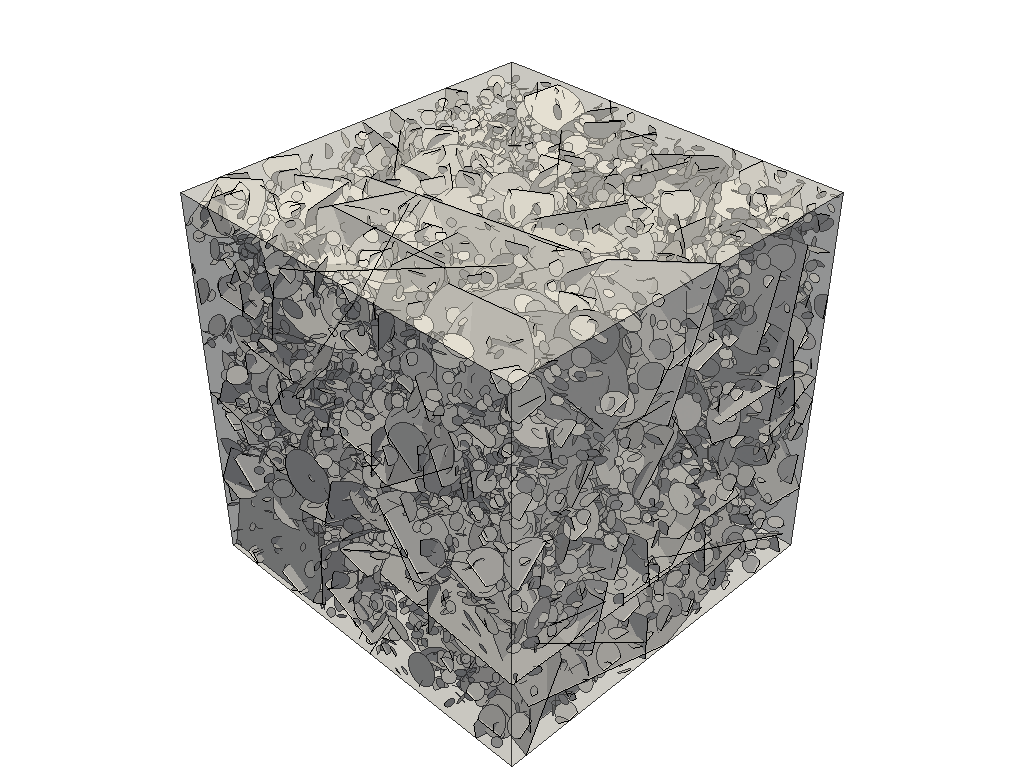

In [6]:
if display:
    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder)
    dfn_io.write_DFN_file(fnet,pathFolder+"/doublet_dfn")
    Aw = dfn_io.DFNIO_Object(fnet)
    Aw.createVTKDataSystem('')
    Aw.createVTKDataGeometries()
    Aw.writeVTKOnSystem(pathFolder+"/doublet_system",True)
    
    
    visu_fnet = pv.read(pathFolder+"/doublet_dfn.vtp")
    visu_sys = pv.read(pathFolder+"/doublet_system.vtp")
    p = pv.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(visu_fnet, color='white', show_edges=True, edge_color='black', lighting=True, show_scalar_bar=True)
    p.add_mesh(visu_sys, color='white', show_edges=True, edge_color='black', lighting=True, show_scalar_bar=True, opacity = 0.5)
    p.show(auto_close=False, use_panel=False)

### Assigning boundary conditions

In order to find the backbone, we need to create the boundary conditions.

In [7]:
bc = dfnBC.DomainBoundaryCondition()
# fixed 0 velocities on the 6 system borders
bc.setFixedFlux(fnet,0,0) # xmin
bc.setFixedFlux(fnet,1,0) # xmax
bc.setFixedFlux(fnet,2,0) # ymin
bc.setFixedFlux(fnet,3,0) # ymax
bc.setFixedFlux(fnet,4,0) # zmin
bc.setFixedFlux(fnet,5,0) # zmax
# set presssure in wells
bc.setWellInBC(fnet, 10, well1)  # the hydraulic charge 10 is applied at well 1
bc.setWellInBC(fnet, -10, well2) # the hydraulic charge -10 is applied at well 2

### Assigning hydraulic properties

We consider that frcture transmissivity is correlated to fracture size following:
$$\log(T_f)=\log(a)+b.\log(\frac{l_f}{2})+\sigma(U[0,1])$$
with $T_f$ the fracture transmissivity, $l_f$ the fracture size, $\sigma$ the standard deviation of the associated noise, $a$ and $b$ the parameters of the power-law relationship between fracture size and transmissivity.

In [8]:
hydro = dfn_hydro.HydraulicProperties(fnet)
hydro.setSizeCorrelated(a=1,b=2,std=0.1)

### Connectivity analysis

The backbone (structure carrying the flow) can be found from fractrue connectivity and boundary conditions.

In [9]:
fnet.computeIntersections()

analyzer = dfnA.DFNGraphAnalyzer(fnet,hydro,bc)
dfn_backbone = analyzer.getGraphDFN(backbone=True)

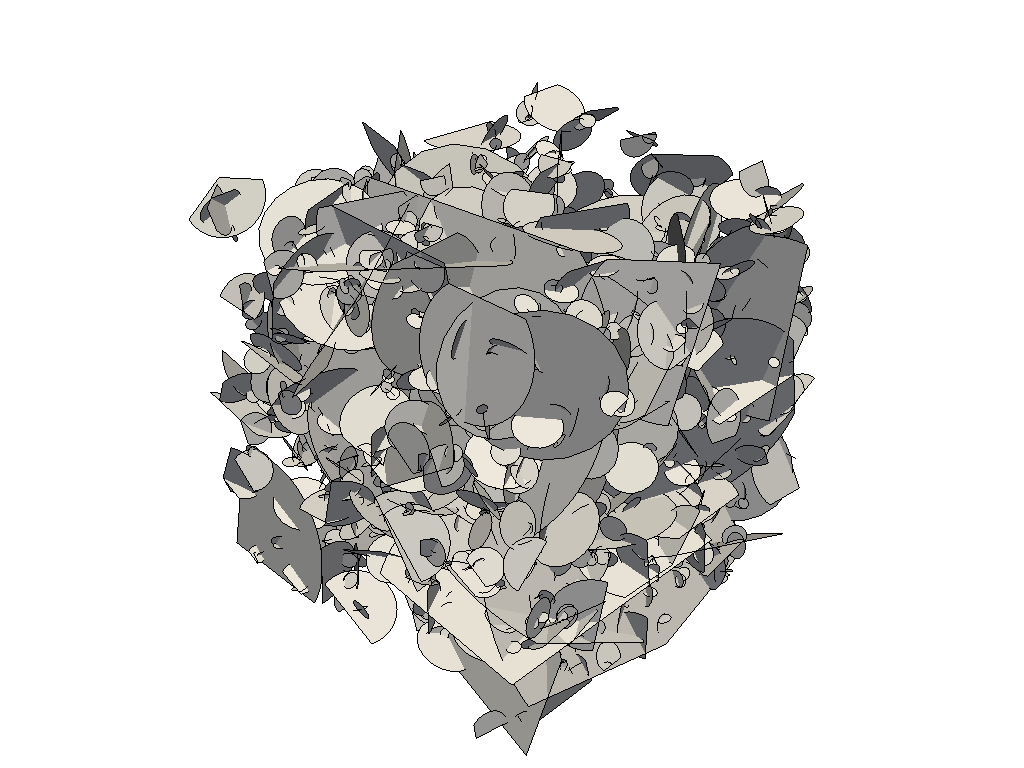

In [10]:
if display:
    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder)
    dfn_io.write_DFN_file(dfn_backbone,pathFolder+"/doublet_backbone")
    
    visu_fnet = pv.read(pathFolder+"/doublet_backbone.vtp")
    p = pv.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(visu_fnet, color='white', show_edges=True, edge_color='black', lighting=True, show_scalar_bar=True)
    p.show(auto_close=False, use_panel=False)

## Creation of the mesh

In [11]:
mesh = dfn_mesh.DFNMesh(dfn_backbone)  
mesh.setCaracteristicLength(5)
mesh.setResolutionIntersection(2)
mesh.setResolutionGeometry(1) 
mesh.setMinimumEdgeLength(0.05) 
mesh.setMaximumEdgeLength(10) 
mesh.setGradation(1.1)  
mesh.setHydraulicProperties(hydro)
mesh.generateMesh()  

4821
MMG_creationOfIntersections
Increase intersection size
MMG_computeIntersectionsOnIntersections
Generation of edges 
0 intersections empty
Jarvis 
check the edges are Delaunay - preparation of angles 
check the edges are Delaunay - criteria 1 and 2 
0 intersections empty
2432 Fractures meshed  OK 
Generation of edges  ok
0 intersections are deleted not well defined after mesh 


0

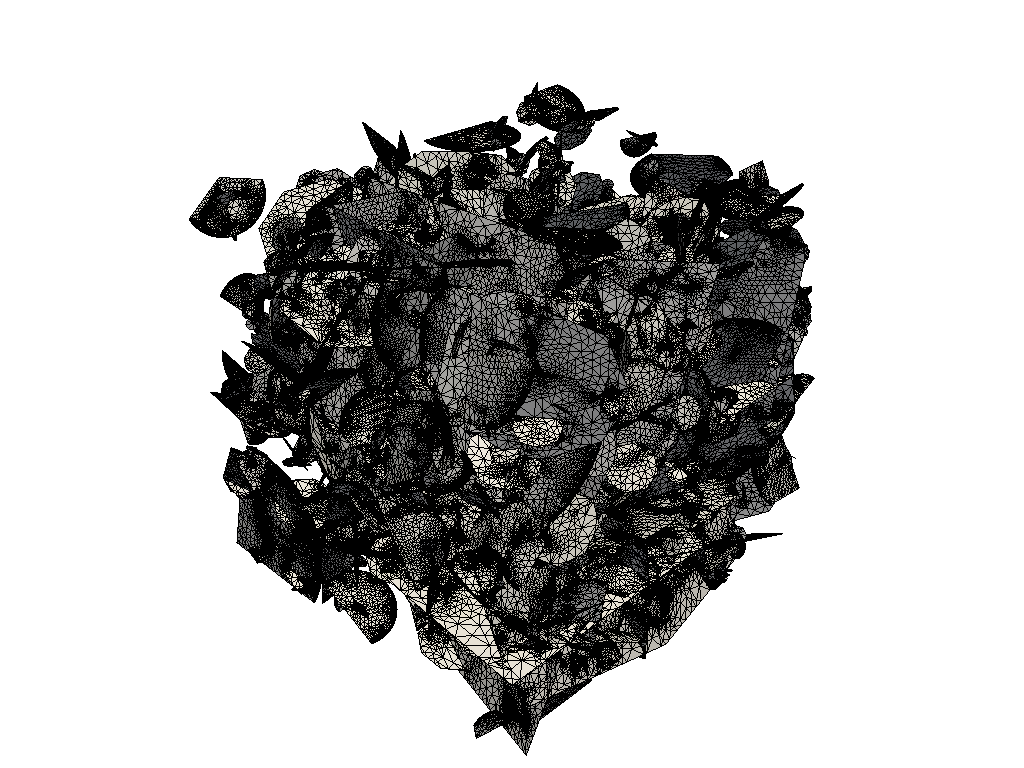

In [12]:
if display:   
    dfn_io.write_mesh_file(mesh,pathFolder+"/doublet_mesh", format="vtp") # format="stl"
    
    visu = pv.read(pathFolder+"/doublet_mesh.vtp")
    p = pv.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(visu, show_edges=True, color='white')
    p.show(auto_close=False, use_panel=False)

## Flow solving

In [13]:
import dfnlab.DFNFlow as dfn_solver
flow = dfn_solver.solveDarcyProblem(mesh,bc,hydro)

Building of the linear system 
Time: to build the system: 8.07788 seconds. 
Taking account of the boundary conditions
Linear System solving
Time: to reconstruct the velocities: 4.35093 seconds. 


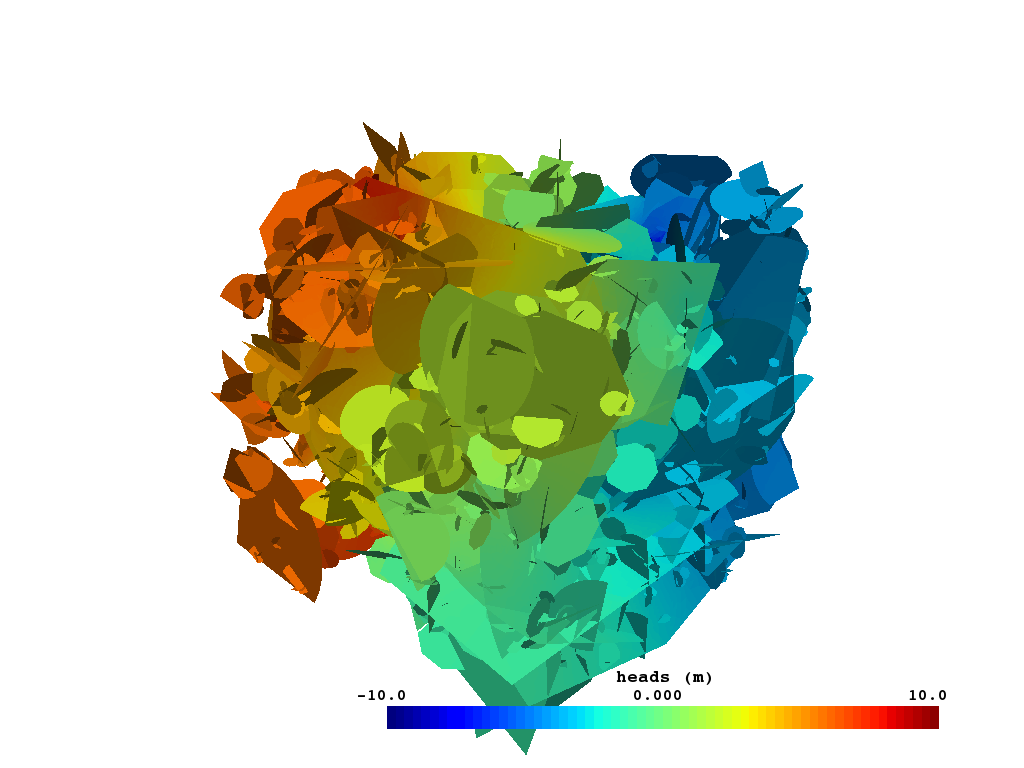

In [14]:
if display:
    

    Aw = dfn_io.DFNIO_Object(mesh)
    Aw.appendDataOnMesh(flow.head(),"heads (m)")
    Aw.appendDataOnMesh(flow.velocity(),"velocities (m/s)")
    Aw.appendDataOnMesh(flow.flow(),"total discharge (m^3/s)")
    Aw.writeVTKOnMesh(pathFolder+"/doublet_flow",True)


    visu = pv.read(pathFolder+"/doublet_flow.vtp")
    p = pv.Plotter(notebook=True)
    argss = dict(color='black', n_labels = 3, title_font_size = 14, label_font_size=12)
    p.set_background('white')
    p.add_mesh(visu,show_edges=False,scalars='heads (m)', cmap='jet', lighting=True, show_scalar_bar=True, scalar_bar_args=argss)
    p.show(auto_close=False, use_panel=False)

In [15]:
inputFlow = flow.getIndicatorsValue(dfn_solver.IndicatorsEnum.inputInFractures)
print("Input flow: {}".format(inputFlow))

outputFlow = flow.getIndicatorsValue(dfn_solver.IndicatorsEnum.outputInFractures)
print("Output flow: {}".format(outputFlow))

print('Relative difference between input and output: '+ ( (inputFlow + outputFlow) / (outputFlow+ 1e-18)).__str__())

totalFluxInSystem = flow.getIndicatorsValue(dfn_solver.IndicatorsEnum.totalFluxInSystem)
print("Total flux is: {}".format(totalFluxInSystem))

k = flow.getIndicatorsValue(dfn_solver.IndicatorsEnum.hydraulicConductivity)
print("Equivalent Hydraulic conductivity is: {}".format(k))

Input flow: 29868.33470469934
Output flow: -31543.39605940818
Relative difference between input and output: 0.05310339291159594
Total flux is: 4.2501059627249705e-10
Equivalent Hydraulic conductivity is: 0.0


## Particles tracking

In [ ]:
import dfnlab.DFNParticlesTracking as dfn_pt

particleSet =  dfn_pt.ParticleSet(flow)
wells = [dfn_backbone.getSystem().getWellTunnel(0)]
particle_generator = dfn_pt.GeneratorOnWellTunnel(mesh,particleSet,wells)
particle_generator.generate(500);
particleSet.setDt(0.001);
particleSet.addExtraInPositionOfParticles('timeOfFlight')
particleSet.saveAllTrajectory()
particleSet.run(5000)

dfn_io.write_particle_file(particleSet,pathFolder+"/particles_path.vtp")

In [ ]:
visu_fnet = pv.read(pathFolder+"/doublet_backbone.vtp")
visu_particles = pv.read(pathFolder+"/particles_path.vtp")
p = pv.Plotter(notebook=True)
argss = dict(color='black', n_labels = 3, title_font_size = 14, label_font_size=12)
p.set_background('white')
visu_particles['log(velocity)'] = np.log(visu_particles['velocity'])
p.add_mesh(visu_fnet, color='white', show_edges=False, lighting=True, show_scalar_bar=True, opacity=0.2)
p.add_mesh(visu_particles,show_edges=False,scalars='log(velocity)', cmap='Blues', lighting=True, show_scalar_bar=True, scalar_bar_args=argss)
p.show(auto_close=False, use_panel=False)

In [ ]:
import matplotlib.pyplot as plt

indicator = particleSet.getTimeOfFlight()
Stat = indicator.getStatisticalDistribution(nBins = 50,logarithmicScale= True, density = True)
X,Pdf = Stat.getPDF()
print('Minimum arrival time {}'.format( Stat.getMinimum()))
print('Mean arrival time {}'.format( Stat.getMean()))
plt.plot(X,Pdf,'-', color = 'k')
plt.xlabel('Particle time of flight', fontsize=18)
plt.ylabel('PDF', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)